0. 데이터셋 압축 해제

In [ ]:
import zipfile
import os

# 압축 파일 경로
zip_source = '/content/drive/MyDrive/Study/Sample.zip'
extract_target = '/content/drive/MyDrive/Study/xray_data'

if not os.path.exists(extract_target):
    with zipfile.ZipFile(zip_source, 'r') as zip_ref:
        zip_ref.extractall(extract_target)
    print("압축 해제 완료!")

1. 필수 라이브러리 및 파라미터 설정

In [ ]:
import os
import json
import glob
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from torchvision.ops import RoIPool, nms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
from tqdm import tqdm
from collections import namedtuple
import six

# torchnet 설치 및 임포트
!pip install torchnet
from torchnet.meter import ConfusionMeter, AverageValueMeter

# --- 하이퍼 파라미터 ---
epochs = 10
learning_rate = 1e-3
lr_decay = 0.1
weight_decay = 0.0005
use_drop = False

rpn_sigma = 3.
roi_sigma = 1.

data_dir = '/content/drive/MyDrive/Study/xray_data/Sample'
num_classes = 317  # 배경 제외 클래스 수
train_load_path = None
inf_load_path = './checkpoints/faster_rcnn_scratch_checkpoints.pth'

2. 유틸리티 함수

In [ ]:
import matplotlib.pyplot as plt

def loc2bbox(src_bbox, loc):
    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)
    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy, dx, dh, dw = loc[:, 0::4], loc[:, 1::4], loc[:, 2::4], loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4], dst_bbox[:, 1::4] = ctr_y - 0.5 * h, ctr_x - 0.5 * w
    dst_bbox[:, 2::4], dst_bbox[:, 3::4] = ctr_y + 0.5 * h, ctr_x + 0.5 * w
    return dst_bbox

def bbox2loc(src_bbox, dst_bbox):
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height, width = np.maximum(height, eps), np.maximum(width, eps)

    dy, dx = (base_ctr_y - ctr_y) / height, (base_ctr_x - ctr_x) / width
    dh, dw = np.log(base_height / height), np.log(base_width / width)
    return np.vstack((dy, dx, dh, dw)).transpose()

def normal_init(m, mean, stddev, truncated=False):
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)
    else:
        m.weight.data.normal_(mean, stddev)
        if m.bias is not None: m.bias.data.zero_()

def get_inside_index(anchor, H, W):
    return np.where((anchor[:, 0] >= 0) & (anchor[:, 1] >= 0) & (anchor[:, 2] <= H) & (anchor[:, 3] <= W))[0]

def unmap(data, count, index, fill=0):
    ret_shape = (count,) if len(data.shape) == 1 else (count,) + data.shape[1:]
    ret = np.empty(ret_shape, dtype=data.dtype)
    ret.fill(fill)
    ret[index] = data
    return ret

def tonumpy(data):
    if isinstance(data, torch.Tensor): return data.detach().cpu().numpy()
    return data

def totensor(data, cuda=True):
    if isinstance(data, np.ndarray): tensor = torch.from_numpy(data)
    else: tensor = data.detach()
    return tensor.cuda() if cuda else tensor

def scalar(data):
    return data.item() if isinstance(data, torch.Tensor) else data.reshape(1)[0]

def bbox_iou(bbox_a, bbox_b):
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])
    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

def plot_metrics(loss_history, final_map):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)

    # mAP (single value)
    plt.subplot(1, 2, 2)
    plt.scatter([epochs[-1]], [final_map], color='orange', s=80)
    plt.text(
        epochs[-1],
        final_map,
        f"{final_map:.3f}",
        ha="right",
        va="bottom"
    )
    plt.xlabel("Epoch")
    plt.ylabel("mAP@0.5")
    plt.title("Final Validation mAP")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

3. 커스텀 데이터셋

In [ ]:
class TrainCustom(Dataset):
    def __init__(self, data_dir, transforms=True):
        self.data_dir = data_dir
        self.transforms = transforms

        # 모든 이미지 재귀적으로 수집
        self.img_paths = sorted(
            glob.glob(
                os.path.join(data_dir, '01.원천데이터', '**', '*.*'),
                recursive=True
            )
        )
        self.img_paths = [
            p for p in self.img_paths
            if p.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        self.id_to_class = {}
        self._build_class_mapping()

    def _build_class_mapping(self):
        """
        category_id (0-based) -> 영어 클래스명 자동 매핑
        이미지 경로의 영어 폴더명을 사용
        """
        for img_path in self.img_paths:
            label_path = self.img_to_label_path(img_path)
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r', encoding='utf-8') as f:
                anno = json.load(f)

            for obj in anno.get("annotations", []):
                class_id = obj["category_id"] - 1  # 0-based

                # 예시 경로:
                # .../01.원천데이터/Gray/위해물품/Zipo lighter/지포라이터(134)/xxx.png
                parts = img_path.split(os.sep)

                if "위해물품" in parts:
                    eng_name = parts[parts.index("위해물품") + 1]
                elif "정보저장매체" in parts:
                    eng_name = parts[parts.index("정보저장매체") + 1]
                else:
                    # fallback (안전장치)
                    eng_name = parts[-3]

                # 정규화 (공백/대문자)
                eng_name = eng_name.lower().replace(" ", "_")

                self.id_to_class[class_id] = eng_name

    def img_to_class_name(self, img_path):
        return img_path.split(os.sep)[-2]

    def img_to_label_path(self, img_path):
        """
        01.원천데이터/Gray(or Color)/정보저장매체/.../xxx.png
        → 02.라벨링데이터/정보저장매체/.../xxx.json
        """
        rel = img_path.split('01.원천데이터/')[1]

        # Gray / Color 제거
        if rel.startswith('Gray/'):
            rel = rel.replace('Gray/', '', 1)
        elif rel.startswith('Color/'):
            rel = rel.replace('Color/', '', 1)

        label_path = os.path.join(
            self.data_dir,
            '02.라벨링데이터',
            rel
        )

        return label_path.replace('.png', '.json').replace('.PNG', '.json') \
                         .replace('.jpg', '.json').replace('.JPG', '.json')

    def __getitem__(self, index):
        img_path = self.img_paths[index]

        # ---- 이미지 로드 ----
        image = cv2.imread(img_path)
        if image is None:
            raise RuntimeError(f"Failed to read image: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # ---- 라벨 로드 ----
        label_path = self.img_to_label_path(img_path)
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label not found:\n{label_path}\nFrom image:\n{img_path}")

        with open(label_path, 'r', encoding='utf-8') as f:
            anno = json.load(f)

        boxes, labels = [], []
        for obj in anno.get('annotations', []):
            x, y, w, h = obj['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(obj['category_id'] - 1)

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        # ---- bbox 없는 이미지 처리 ----
        if len(boxes) == 0:
            # 최소한 한 개 dummy box (trainer 안정화용)
            boxes = np.zeros((1, 4), dtype=np.float32)
            labels = np.zeros((1,), dtype=np.int64)

        # ---- Transform ----
        H, W, _ = image.shape
        aug = get_train_transform(H, W) if self.transforms else no_transform()
        sample = aug(image=image, bboxes=boxes, labels=labels)

        image = sample['image']
        bboxes = np.array(sample['bboxes'], dtype=np.float32)
        labels = torch.as_tensor(sample["labels"], dtype=torch.int64)

        # (x1,y1,x2,y2) → (y1,x1,y2,x2)
        if len(bboxes) > 0:
            bboxes = bboxes[:, [1, 0, 3, 2]]

        return image, torch.tensor(bboxes, dtype=torch.float32), labels, 1.0

    def __len__(self):
        return len(self.img_paths)

# Train dataset transform
def get_train_transform(h, w):
    return A.Compose([
        A.Resize(height = h, width = w),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# No transform
def no_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # format for pytorch tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


4. Faster R-CNN 모델 구성 (RPN, Head, Main)

In [ ]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    py, px = base_size / 2., base_size / 2.
    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])
            index = i * len(anchor_scales) + j
            anchor_base[index, 0], anchor_base[index, 1] = py - h / 2., px - w / 2.
            anchor_base[index, 2], anchor_base[index, 3] = py + h / 2., px + w / 2.
    return anchor_base

class ProposalCreator:
    def __init__(self, parent_model, nms_thresh=0.7, n_train_pre_nms=12000, n_train_post_nms=2000, n_test_pre_nms=6000, n_test_post_nms=300, min_size=16):
        self.parent_model = parent_model
        self.nms_thresh, self.min_size = nms_thresh, min_size
        self.n_train_pre_nms, self.n_train_post_nms = n_train_pre_nms, n_train_post_nms
        self.n_test_pre_nms, self.n_test_post_nms = n_test_pre_nms, n_test_post_nms

    def __call__(self, loc, score, anchor, img_size, scale=1.):
        n_pre, n_post = (self.n_train_pre_nms, self.n_train_post_nms) if self.parent_model.training else (self.n_test_pre_nms, self.n_test_post_nms)
        roi = loc2bbox(anchor, loc)
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

        hs, ws = roi[:, 2] - roi[:, 0], roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= self.min_size * scale) & (ws >= self.min_size * scale))[0]
        roi, score = roi[keep, :], score[keep]

        order = score.ravel().argsort()[::-1][:n_pre]
        roi, score = roi[order, :], score[order]

        keep = nms(torch.from_numpy(roi).cuda(), torch.from_numpy(score).cuda(), self.nms_thresh)
        return roi[keep[:n_post].cpu().numpy()]

class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32], feat_stride=16):
        super().__init__()
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        for m in [self.conv1, self.score, self.loc]: normal_init(m, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(self.anchor_base, self.feat_stride, hh, ww)
        n_anchor = anchor.shape[0] // (hh * ww)
        middle = F.relu(self.conv1(x))
        rpn_locs = self.loc(middle).permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(middle).permute(0, 2, 3, 1).contiguous()
        rpn_fg_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)[:, :, :, :, 1].contiguous().view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois, roi_indices = [], []
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i].cpu().data.numpy(), rpn_fg_scores[i].cpu().data.numpy(), anchor, img_size, scale)
            rois.append(roi)
            roi_indices.append(i * np.ones((len(roi),), dtype=np.int32))
        return rpn_locs, rpn_scores, np.concatenate(rois), np.concatenate(roi_indices), anchor

def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    shift_y, shift_x = np.arange(0, height * feat_stride, feat_stride), np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(), shift_y.ravel(), shift_x.ravel()), axis=1)
    K, A = shift.shape[0], anchor_base.shape[0]
    return (anchor_base.reshape((1, A, 4)) + shift.reshape((1, K, 4)).transpose((1, 0, 2))).reshape((K * A, 4)).astype(np.float32)

def decom_vgg16():
    model = vgg16(pretrained=True)
    features = list(model.features)[:30]
    classifier = list(model.classifier)
    del classifier[6]
    if not use_drop: del classifier[5], classifier[2]
    for layer in features[:10]:
        for p in layer.parameters(): p.requires_grad = False
    return nn.Sequential(*features), nn.Sequential(*classifier)

class VGG16RoIHead(nn.Module):
    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super().__init__()
        self.classifier = classifier
        self.cls_loc, self.score = nn.Linear(4096, n_class * 4), nn.Linear(4096, n_class)
        normal_init(self.cls_loc, 0, 0.001); normal_init(self.score, 0, 0.01)
        self.n_class, self.roi_size, self.spatial_scale = n_class, roi_size, spatial_scale
        self.roi = RoIPool((roi_size, roi_size), spatial_scale)

    def forward(self, x, rois, roi_indices):
        roi_indices, rois = totensor(roi_indices).float(), totensor(rois).float()
        indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]].contiguous()
        pool = self.roi(x, xy_indices_and_rois).view(indices_and_rois.size(0), -1)
        fc7 = self.classifier(pool)
        return self.cls_loc(fc7), self.score(fc7)

class FasterRCNN(nn.Module):
    def __init__(self, extractor, rpn, head):
        super().__init__()
        self.extractor, self.rpn, self.head = extractor, rpn, head
        self.loc_normalize_mean, self.loc_normalize_std = (0., 0., 0., 0.), (0.1, 0.1, 0.2, 0.2)
        self.nms_thresh, self.score_thresh = 0.3, 0.05

    def forward(self, x, scale=1.):
        img_size = x.shape[2:]
        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, _ = self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    @torch.no_grad()
    def predict(self, imgs, sizes):
        self.eval()
        bboxes, labels, scores = [], [], []
        for img, size in zip(imgs, sizes):
            img = totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_score, rois, _ = self(img, scale=scale)
            roi = totensor(rois) / scale

            mean = torch.Tensor(self.loc_normalize_mean).cuda().repeat(self.head.n_class)[None]
            std = torch.Tensor(self.loc_normalize_std).cuda().repeat(self.head.n_class)[None]
            roi_cls_loc = (roi_cls_loc * std + mean).view(-1, self.head.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)

            cls_bbox = loc2bbox(tonumpy(roi).reshape(-1, 4), tonumpy(roi_cls_loc).reshape(-1, 4))
            cls_bbox = totensor(cls_bbox).view(-1, self.head.n_class * 4)
            cls_bbox[:, 0::2].clamp_(0, size[0]); cls_bbox[:, 1::2].clamp_(0, size[1])

            prob = F.softmax(roi_score, dim=1)
            bbox_p, label_p, score_p = self._suppress(cls_bbox, prob)
            bboxes.append(bbox_p); labels.append(label_p); scores.append(score_p)
        self.train()
        return bboxes, labels, scores

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox, label, score = [], [], []
        for l in range(1, self.head.n_class):
            cls_bbox_l = raw_cls_bbox.view(-1, self.head.n_class, 4)[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l, prob_l = cls_bbox_l[mask], prob_l[mask]
            keep = nms(cls_bbox_l, prob_l, self.nms_thresh)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())
        return np.concatenate(bbox), np.concatenate(label), np.concatenate(score)

    def get_optimizer(self):
        params = []
        for key, value in self.named_parameters():
            if value.requires_grad:
                lr = learning_rate * (2 if 'bias' in key else 1)
                wd = 0 if 'bias' in key else weight_decay
                params.append({'params': [value], 'lr': lr, 'weight_decay': wd})
        self.optimizer = torch.optim.SGD(params, momentum=0.9)
        return self.optimizer

class FasterRCNNVGG16(FasterRCNN):
    def __init__(self, n_fg_class=317):
        extractor, classifier = decom_vgg16()
        rpn = RegionProposalNetwork(512, 512)
        head = VGG16RoIHead(n_class=n_fg_class + 1, roi_size=7, spatial_scale=1/16, classifier=classifier)
        super().__init__(extractor, rpn, head)

5. Trainer 클래스

In [ ]:
class AnchorTargetCreator:
    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample, self.pos_iou_thresh, self.neg_iou_thresh, self.pos_ratio = n_sample, pos_iou_thresh, neg_iou_thresh, pos_ratio

    def __call__(self, bbox, anchor, img_size):
        H, W = img_size
        inside_index = get_inside_index(anchor, H, W)
        anchor_inside = anchor[inside_index]

        argmax_ious, label = self._create_label(inside_index, anchor_inside, bbox)
        loc = bbox2loc(anchor_inside, bbox[argmax_ious])

        return unmap(loc, len(anchor), inside_index, 0), unmap(label, len(anchor), inside_index, -1)

    def _create_label(self, inside_index, anchor, bbox):
        label = -np.ones((len(inside_index),), dtype=np.int32)
        ious = bbox_iou(anchor, bbox)
        argmax_ious = ious.argmax(axis=1)
        max_ious = ious.max(axis=1)
        gt_argmax_ious = ious.argmax(axis=0)

        label[max_ious < self.neg_iou_thresh] = 0
        label[gt_argmax_ious] = 1
        label[max_ious >= self.pos_iou_thresh] = 1

        pos_index = np.where(label == 1)[0]
        n_pos = int(self.pos_ratio * self.n_sample)
        if len(pos_index) > n_pos:
            label[np.random.choice(pos_index, len(pos_index) - n_pos, replace=False)] = -1

        neg_index = np.where(label == 0)[0]
        n_neg = self.n_sample - np.sum(label == 1)
        if len(neg_index) > n_neg:
            label[np.random.choice(neg_index, len(neg_index) - n_neg, replace=False)] = -1
        return argmax_ious, label

class ProposalTargetCreator:
    def __init__(self, n_sample=128, pos_ratio=0.25, pos_iou_thresh=0.5, neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0):
        self.n_sample, self.pos_ratio, self.pos_iou_thresh = n_sample, pos_ratio, pos_iou_thresh
        self.neg_iou_thresh_hi, self.neg_iou_thresh_lo = neg_iou_thresh_hi, neg_iou_thresh_lo

    def __call__(self, roi, bbox, label, loc_normalize_mean=(0.,0.,0.,0.), loc_normalize_std=(0.1,0.1,0.2,0.2)):
        roi = np.concatenate((roi, bbox), axis=0)
        ious = bbox_iou(roi, bbox)
        gt_assignment = ious.argmax(axis=1)
        max_iou = ious.max(axis=1)
        gt_roi_label = label[gt_assignment] + 1

        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        n_pos = int(min(np.round(self.n_sample * self.pos_ratio), pos_index.size))
        if pos_index.size > 0: pos_index = np.random.choice(pos_index, size=n_pos, replace=False)

        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) & (max_iou >= self.neg_iou_thresh_lo))[0]
        n_neg = int(min(self.n_sample - n_pos, neg_index.size))
        if neg_index.size > 0: neg_index = np.random.choice(neg_index, size=n_neg, replace=False)

        keep_index = np.append(pos_index, neg_index)
        sample_roi = roi[keep_index]
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[n_pos:] = 0
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = (gt_roi_loc - np.array(loc_normalize_mean)) / np.array(loc_normalize_std)
        return sample_roi, gt_roi_loc, gt_roi_label

class FasterRCNNTrainer(nn.Module):
    def __init__(self, faster_rcnn):
        super().__init__()
        self.faster_rcnn = faster_rcnn
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()
        self.optimizer = faster_rcnn.get_optimizer()

        # 수정: ConfusionMeter 크기를 실제 클래스 개수(+배경)에 맞게 설정
        self.rpn_cm = ConfusionMeter(2)
        self.roi_cm = ConfusionMeter(num_classes + 1)
        self.meters = {k: AverageValueMeter() for k in ['rpn_loc_loss', 'rpn_cls_loss', 'roi_loc_loss', 'roi_cls_loss', 'total_loss']}

    def forward(self, imgs, bboxes, labels, scale):
        _, _, H, W = imgs.shape
        features = self.faster_rcnn.extractor(imgs)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(features, (H, W), scale)

        bbox, label = bboxes[0], labels[0]
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(rois, tonumpy(bbox), tonumpy(label))
        roi_cls_loc, roi_score = self.faster_rcnn.head(features, sample_roi, torch.zeros(len(sample_roi)))

        # Losses
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(tonumpy(bbox), anchor, (H, W))
        rpn_cls_loss = F.cross_entropy(rpn_scores[0], totensor(gt_rpn_label).long(), ignore_index=-1)
        rpn_loc_loss = _fast_rcnn_loc_loss(rpn_locs[0], totensor(gt_rpn_loc), totensor(gt_rpn_label).long(), rpn_sigma)

        roi_cls_loss = F.cross_entropy(roi_score, totensor(gt_roi_label).long())
        n_sample = roi_cls_loc.shape[0]
        roi_loc = roi_cls_loc.view(n_sample, -1, 4)[torch.arange(n_sample).long().cuda(), totensor(gt_roi_label).long()]
        roi_loc_loss = _fast_rcnn_loc_loss(roi_loc, totensor(gt_roi_loc), totensor(gt_roi_label).long(), roi_sigma)

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        total_loss = sum(losses)

        # Metrics update
        self.rpn_cm.add(rpn_scores[0][gt_rpn_label > -1].detach(), totensor(gt_rpn_label[gt_rpn_label > -1]).long())
        self.roi_cm.add(roi_score.detach(), totensor(gt_roi_label).long())

        loss_dict = {'rpn_loc_loss': rpn_loc_loss, 'rpn_cls_loss': rpn_cls_loss, 'roi_loc_loss': roi_loc_loss, 'roi_cls_loss': roi_cls_loss, 'total_loss': total_loss}
        for k, v in loss_dict.items(): self.meters[k].add(scalar(v))

        return total_loss

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        loss = self.forward(imgs, bboxes, labels, scale)
        loss.backward()
        self.optimizer.step()
        return loss

    def save(self, path='./checkpoints/faster_rcnn_scratch.pth'):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({'model': self.faster_rcnn.state_dict(), 'optimizer': self.optimizer.state_dict()}, path)

def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    return (flag * (sigma2 / 2.) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5 / sigma2)).sum()

def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight)] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    return loc_loss / ((gt_label >= 0).sum().float())

6-1. 실행 (mAP)

In [ ]:
import numpy as np
import torch


def compute_iou(boxA, boxB):
    """
    box: (y1, x1, y2, x2)
    """
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    inter = max(0, yB - yA) * max(0, xB - xA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter / (areaA + areaB - inter + 1e-6)


def evaluate_map(
    model,
    dataset,
    iou_thresh=0.5,
    score_thresh=0.3,
    max_samples=300
):
    """
    간단한 mAP@0.5 (추세 확인용)
    - COCO 정식 mAP 아님
    - 학습이 제대로 되고 있는지 확인하는 용도
    """

    model.eval()

    TP, FP, FN = 0, 0, 0
    indices = np.random.choice(
        len(dataset),
        min(len(dataset), max_samples),
        replace=False
    )

    with torch.no_grad():
        for idx in indices:
            img, gt_boxes, _, _ = dataset[idx]
            H, W = img.shape[1:]

            pred_boxes, _, pred_scores = model.predict(
                [img], [(H, W)]
            )

            gt_boxes = gt_boxes.cpu().numpy()
            matched = [False] * len(gt_boxes)

            for pb, ps in zip(pred_boxes[0], pred_scores[0]):
                if ps < score_thresh:
                    continue

                if len(gt_boxes) == 0:
                    FP += 1
                    continue

                ious = [compute_iou(pb, gb) for gb in gt_boxes]
                max_iou = max(ious)
                max_idx = int(np.argmax(ious))

                if max_iou >= iou_thresh and not matched[max_idx]:
                    TP += 1
                    matched[max_idx] = True
                else:
                    FP += 1

            FN += matched.count(False)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)

    model.train()

    # 간이 mAP proxy
    return precision * recall


6-2. 실행 (Train)

In [ ]:
# 학습 담당 - Loss + mAP 출력, 모델 저장
def train():
    dataset = TrainCustom(data_dir)
    val_dataset = dataset  # validation split 없으므로 동일 데이터 사용

    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=2
    )

    model = FasterRCNNVGG16(num_classes).cuda()
    trainer = FasterRCNNTrainer(model).cuda()

    best_loss = 1e9

    # history 저장
    loss_history = []
    final_map = None

    for epoch in range(epochs):
        trainer.meters = {
            k: AverageValueMeter()
            for k in trainer.meters.keys()
        }

        for img, bbox, label, scale in tqdm(dataloader):
            trainer.train_step(
                img.cuda(),
                bbox.cuda(),
                label.cuda(),
                float(scale)
            )

        avg_loss = trainer.meters["total_loss"].value()[0]
        loss_history.append(avg_loss)

        if epoch == epochs - 1:
            final_map = evaluate_map(
                model,
                val_dataset,
                iou_thresh=0.5,
                score_thresh=0.3,
                max_samples=300
            )

            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Loss: {avg_loss:.4f} | Final mAP@0.5: {final_map:.4f}"
            )
        else:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Loss: {avg_loss:.4f}"
            )

        if avg_loss < best_loss:
            best_loss = avg_loss
            trainer.save()

    plot_metrics(loss_history, final_map)

    return model, loss_history, final_map


7. 세팅 확인

In [ ]:
dataset = TrainCustom(data_dir)
print("Number of images:", len(dataset))

Number of images: 5002


In [ ]:
img, bboxes, labels, scale = dataset[0]

print("img:", img.shape)
print("bboxes:", bboxes.shape)
print("labels:", labels.shape)
print("labels unique:", labels.unique())

img: torch.Size([3, 760, 896])
bboxes: torch.Size([1, 4])
labels: torch.Size([1])
labels unique: tensor([70])


8. 학습

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 85.1MB/s]
100%|██████████| 5002/5002 [29:19<00:00,  2.84it/s]


Epoch 1/10 - Loss: 0.4201


100%|██████████| 5002/5002 [20:12<00:00,  4.13it/s]


Epoch 2/10 - Loss: 0.2904


100%|██████████| 5002/5002 [20:10<00:00,  4.13it/s]


Epoch 3/10 - Loss: 0.2388


100%|██████████| 5002/5002 [20:12<00:00,  4.12it/s]


Epoch 4/10 - Loss: 0.2094


100%|██████████| 5002/5002 [20:14<00:00,  4.12it/s]


Epoch 5/10 - Loss: 0.1934


100%|██████████| 5002/5002 [20:12<00:00,  4.13it/s]


Epoch 6/10 - Loss: 0.1787


100%|██████████| 5002/5002 [20:13<00:00,  4.12it/s]


Epoch 7/10 - Loss: 0.1691


100%|██████████| 5002/5002 [20:13<00:00,  4.12it/s]


Epoch 8/10 - Loss: 0.1595


100%|██████████| 5002/5002 [20:15<00:00,  4.12it/s]


Epoch 9/10 - Loss: 0.1555


100%|██████████| 5002/5002 [20:15<00:00,  4.12it/s]


Epoch 10/10 - Loss: 0.1528 | Final mAP@0.5: 0.5995


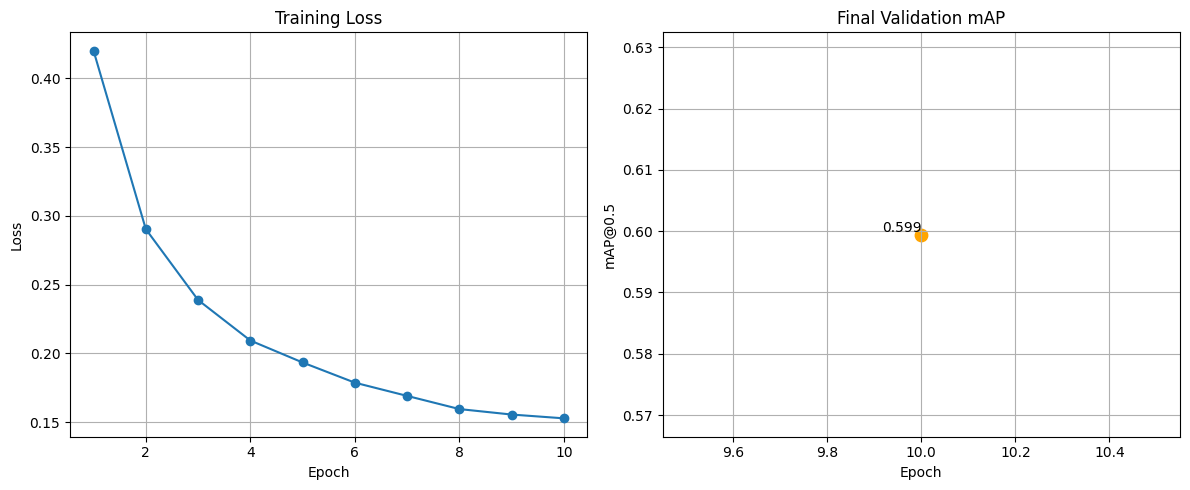

(FasterRCNNVGG16(
   (extractor): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2,

In [ ]:
train()

9. 정성 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import random
import os

def visualize_predictions(model, dataset, num_samples=6, score_thresh=0.3):
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img, gt_bboxes, gt_labels, _ = dataset[idx]
        H, W = img.shape[1:]

        with torch.no_grad():
            bboxes, labels, scores = model.predict(
                [img], [(H, W)]
            )

        fig, ax = plt.subplots(1, figsize=(8, 6))
        img_np = img.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_np)

        # --------------------
        # GT (green)
        # --------------------
        for box in gt_bboxes:
            y1, x1, y2, x2 = box
            ax.add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor="lime",
                    linewidth=2,
                )
            )

        # --------------------
        # Prediction (red)
        # --------------------
        for box, label, score in zip(bboxes[0], labels[0], scores[0]):
            if score < score_thresh:
                continue

            y1, x1, y2, x2 = box

            # class name (GT 기준, 디버깅/발표용)
            pred_id = int(label)
            class_name = dataset.id_to_class.get(pred_id, f"class_{pred_id}")

            ax.add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor="red",
                    linewidth=2,
                )
            )

            ax.text(
                x1, y1,
                f"{class_name} ({score:.2f})",
                color="red",
                fontsize=9,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )

        ax.set_title(f"Sample {idx}")
        ax.axis("off")
        plt.show()

    model.train()

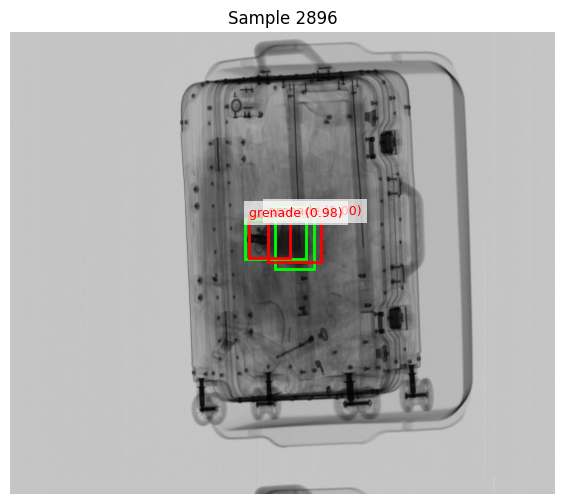

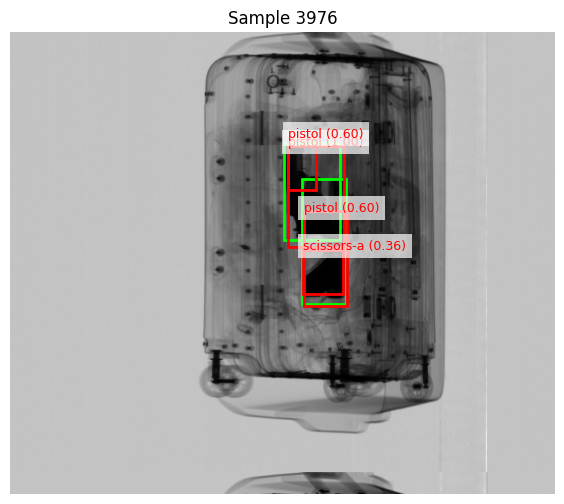

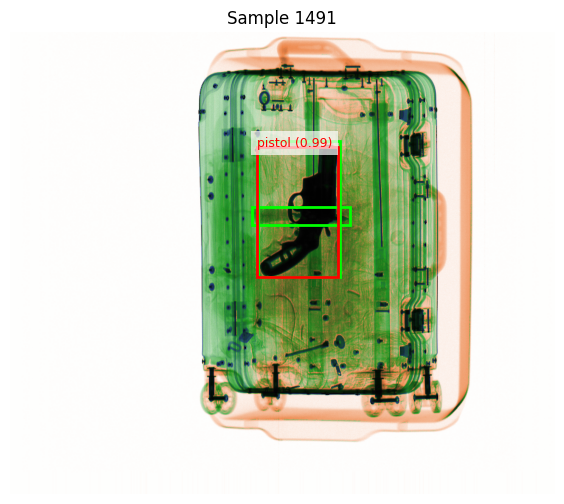

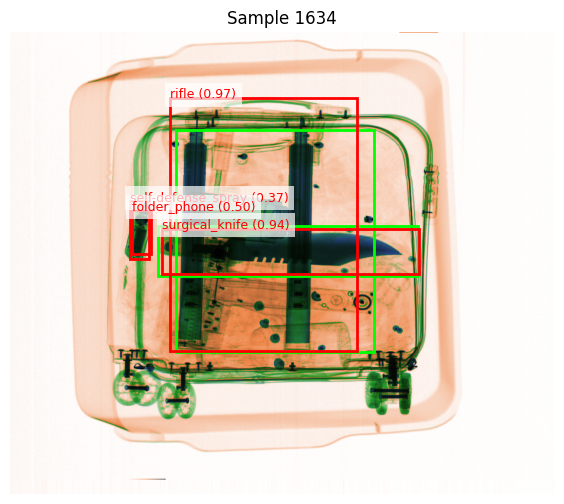

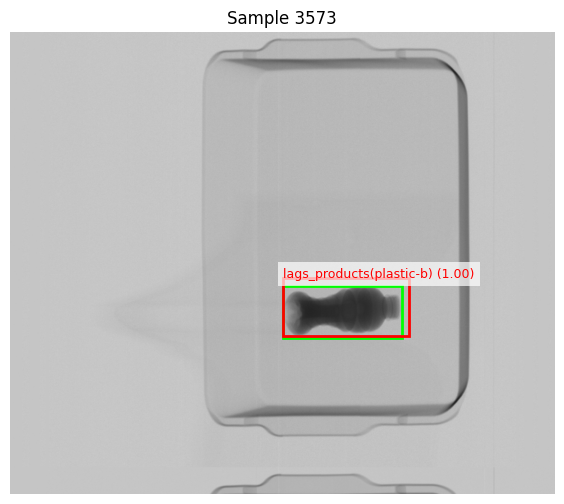

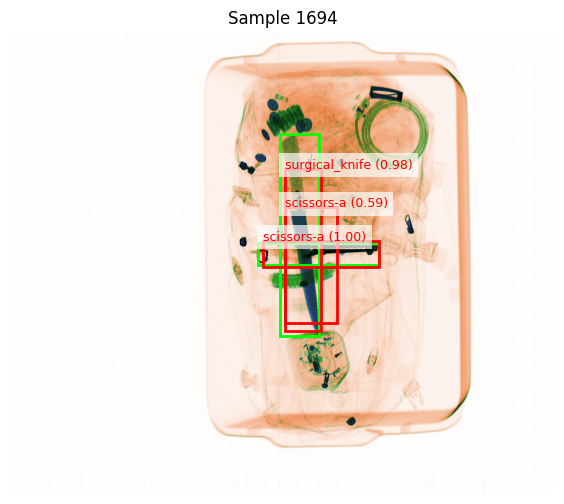

In [ ]:
model = FasterRCNNVGG16(num_classes).cuda()
model.load_state_dict(torch.load("./checkpoints/faster_rcnn_scratch.pth")["model"])

visualize_predictions(model, dataset, num_samples=6, score_thresh=0.3)
